## Importieren

In [1]:
### importiern von notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
### einlesen der Daten von Real 3 und VR 2

data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)



/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_54071/82876672.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_54071/82876672.py:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)


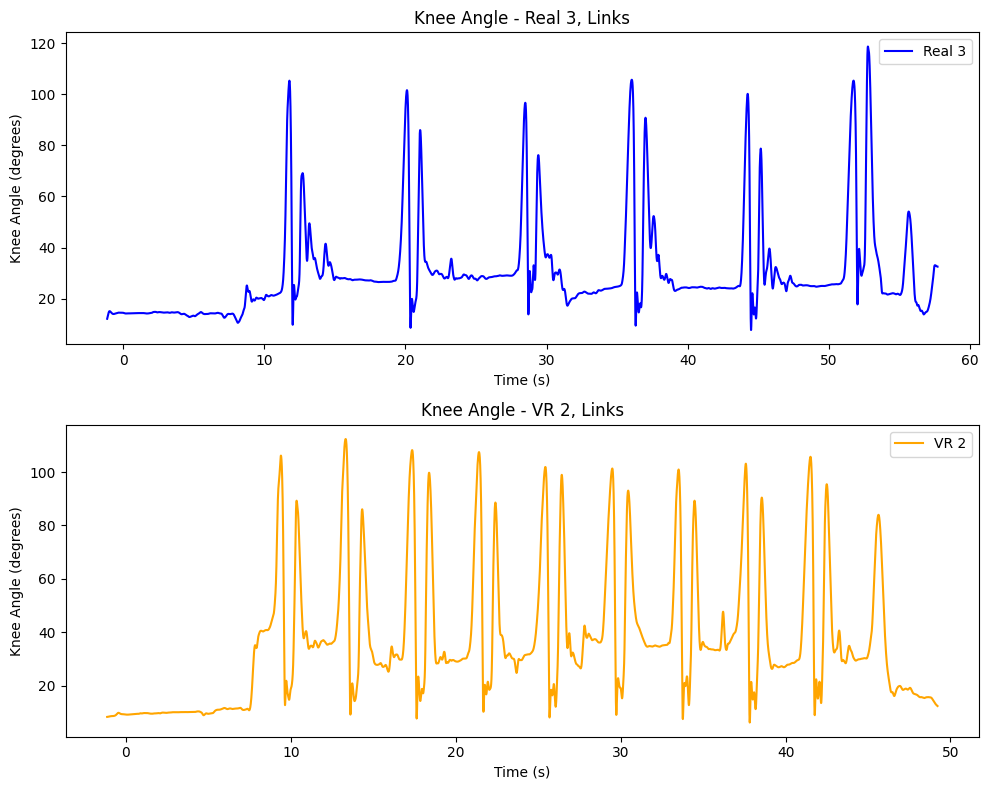

In [3]:
### Plotten des Knie winkel für Real 3 und VR 2 in zwei plots untereinader

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(data_real3['time'], data_real3['LT Knee Flexion (deg)'], label='Real 3', color='blue')
plt.title('Knee Angle - Real 3, Links')
plt.xlabel('Time (s)')
plt.ylabel('Knee Angle (degrees)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_vr2['time'], data_vr2['LT Knee Flexion (deg)'], label='VR 2', color='orange')
plt.title('Knee Angle - VR 2, Links')
plt.xlabel('Time (s)')
plt.ylabel('Knee Angle (degrees)')
plt.legend()
plt.tight_layout()
plt.show()


